In [1]:
import pandas as pd
import pickle
import re

from utilities import predictions
from utilities.info import *

In [2]:
FILE_DIR

'C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/files'

NOTE: This includes the De Haas model (unused for MELBA paper). To load predictions, use these directories: `NLST_Tijmen_results`, `Tijmen_Local_NLST`, `Tijmen-Global-Hidden-NLST`, `Tijmen-Global-ShowNodule-NLST`.

## Load and Calibrate DLCST Predictions

In [3]:
dlcst_preds = pd.read_csv(f"{FILE_DIR}/dlcst_allmodels.csv")
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

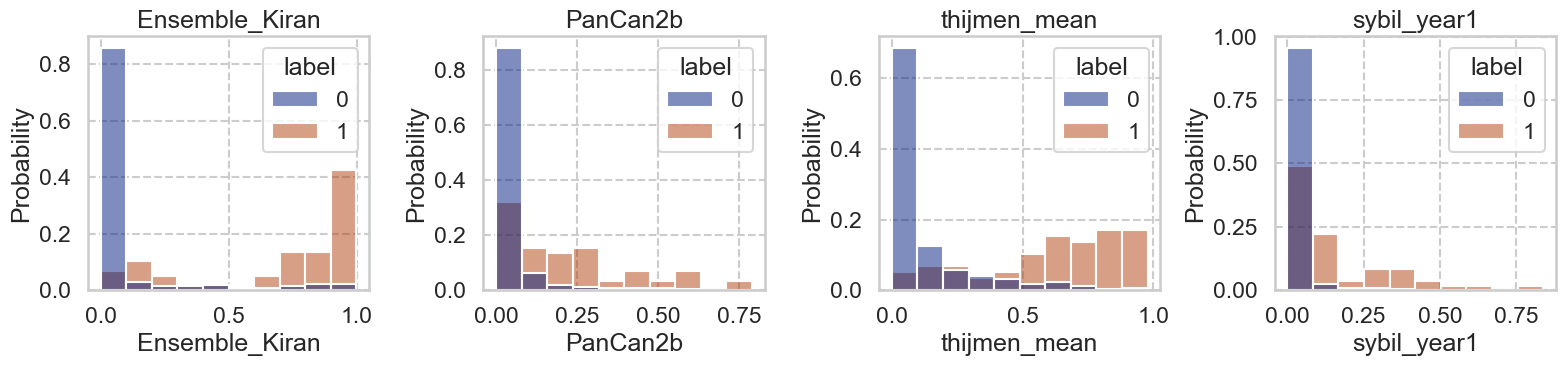

In [4]:
_ = predictions.check_scoredists(dlcst_preds, ['Ensemble_Kiran', 'PanCan2b', 'thijmen_mean', 'sybil_year1'])

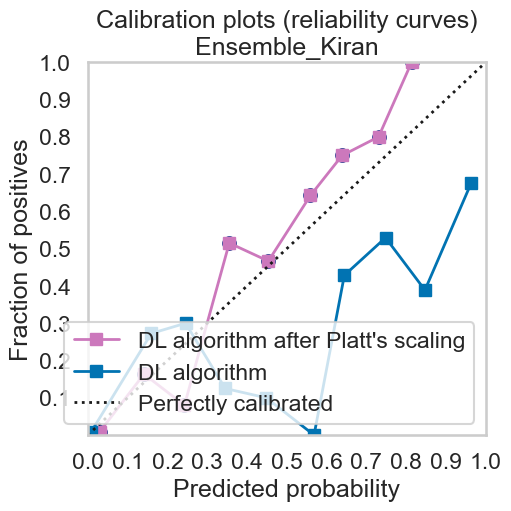

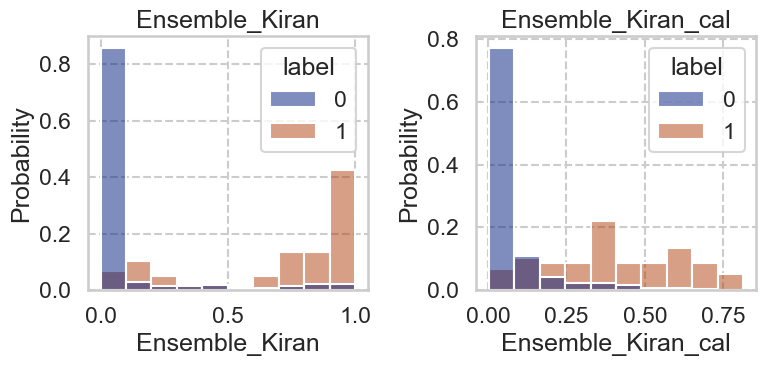

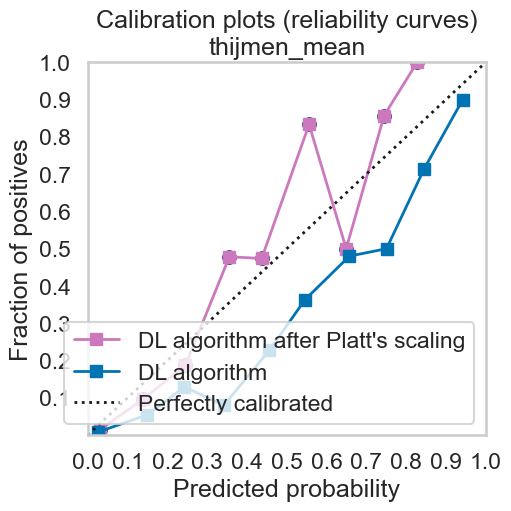

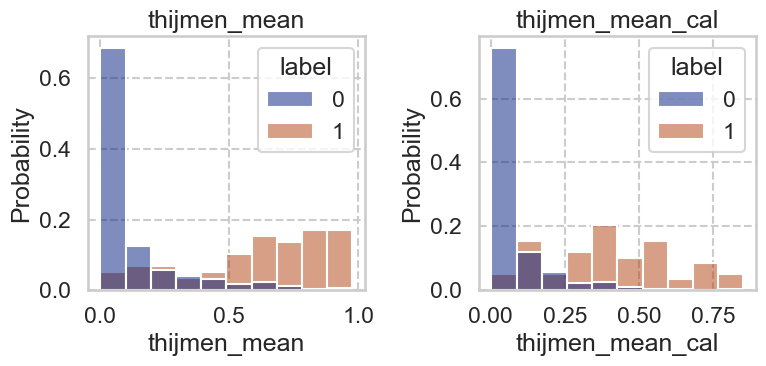

In [ ]:
for model in ['Ensemble_Kiran', 'thijmen_mean']:
    dlcst_preds[f"{model}_cal"] = predictions.calibrate_preds(dlcst_preds[model], dlcst_preds['label'])
    predictions.make_calibration_plots(
        dlcst_preds['label'], dlcst_preds[model], dlcst_preds[f'{model}_cal'], 
        title=f'\n{model}')
    predictions.check_scoredists(dlcst_preds, [model, f'{model}_cal'])

In [6]:
dlcst_preds.to_csv(f"{FILE_DIR}/dlcst_allmodels_cal.csv", index=False)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

## Load Venk21 and PanCan Predictions (NLST)

In [7]:
venk21_pancan = pd.read_csv(f"{FILE_DIR}/NLST_DL_vs_PanCan_Venk21.csv")
venk21_pancan.rename(columns={'Diameter [mm]': 'Diameter_mm'}, inplace=True)
venk21_pancan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

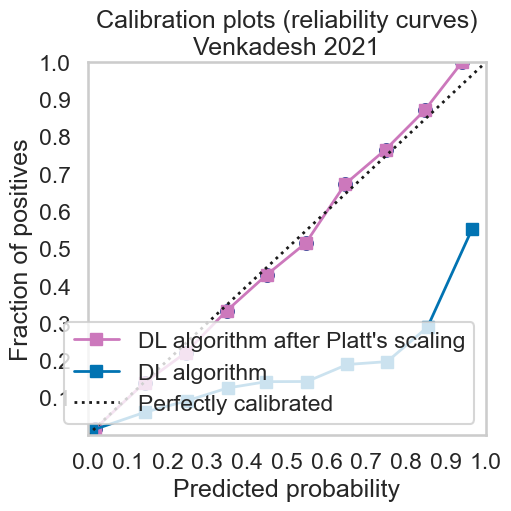

In [8]:
venk21_pancan['DL_cal'] = predictions.calibrate_preds(venk21_pancan['DL'], venk21_pancan['label'])
_= predictions.make_calibration_plots(venk21_pancan['label'], venk21_pancan['DL'], venk21_pancan['DL_cal'], title='\nVenkadesh 2021')

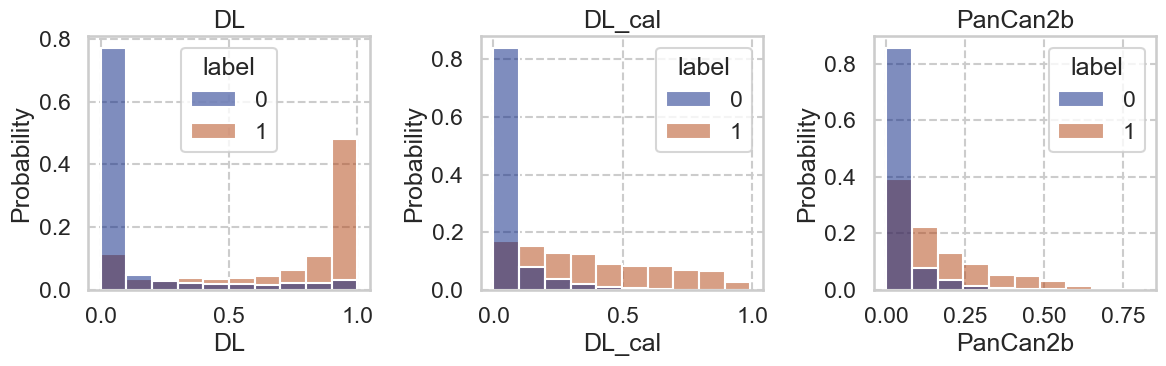

In [9]:
_ = predictions.check_scoredists(venk21_pancan, ['DL', 'DL_cal', 'PanCan2b'])

## Load De Haas Models

In [10]:
tijmen_load_info = {
    "Thijmen_mean": {
        "base_path": rf"{FILE_DIR}/NLST_Tijmen_results/final_layer_nlst_validtion_20240626",
        "local": False,
        "valid": False,
    },
    "Thijmen_local": {
        "base_path": rf"{FILE_DIR}/Tijmen Local NLST",
        "local": True,
        "valid": True,
    },
    "Thijmen_global_hidden": {
        "base_path": rf"{FILE_DIR}/Tijmen-Global-Hidden-NLST/clip_hidden_nod_global_nlst_logits_20240422",
        "local": False,
        "valid": True,
    },
    "Thijmen_global_show": {
        "base_path": rf"{FILE_DIR}/Tijmen-Global-ShowNodule-NLST/clip_show_nod_global_nlst_20240501",
        "local": False,
        "valid": True,
    }, 
}

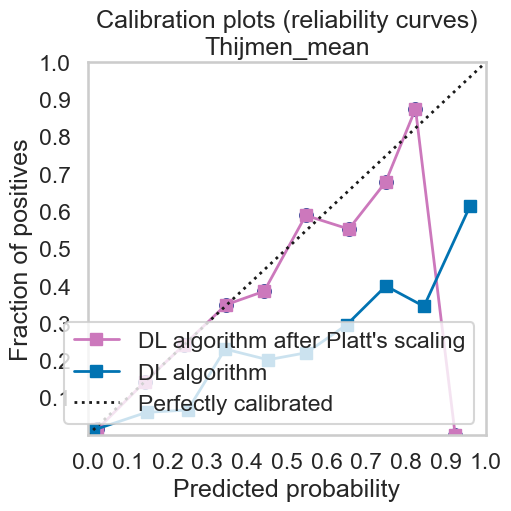

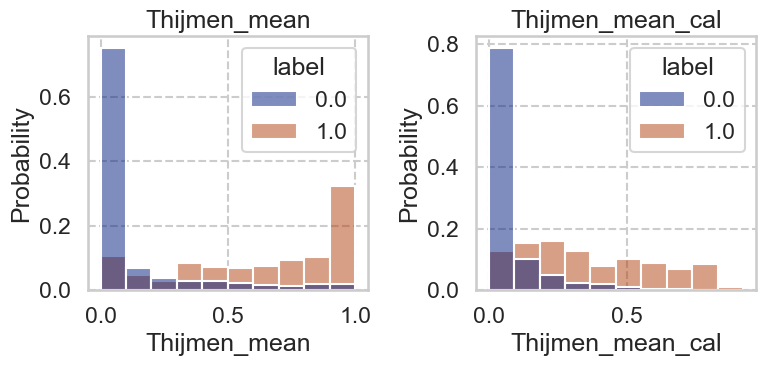

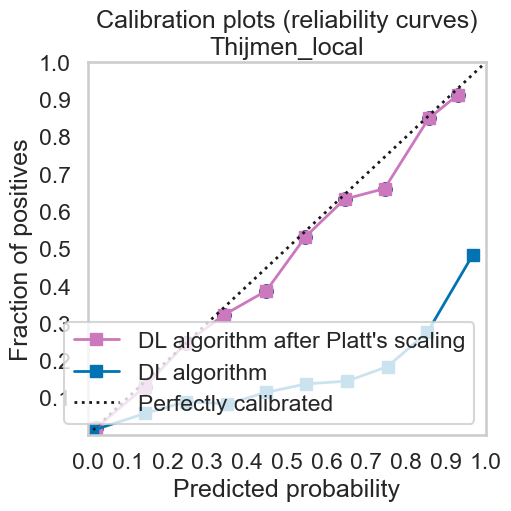

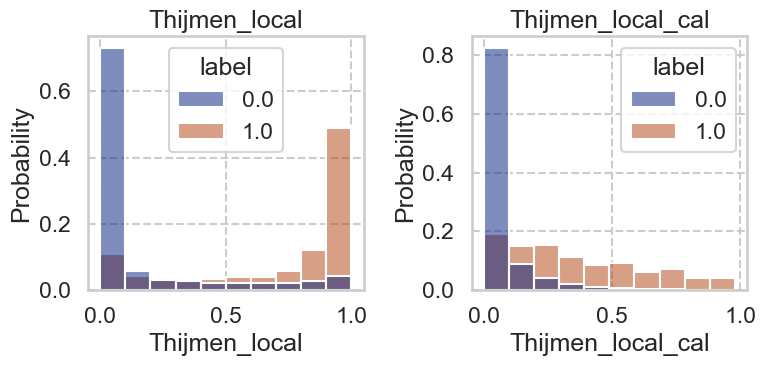

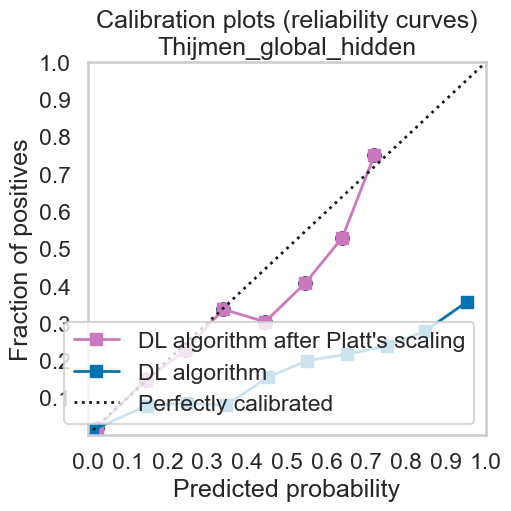

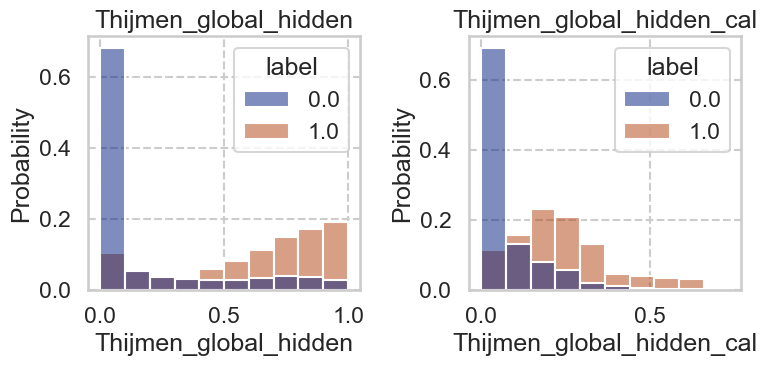

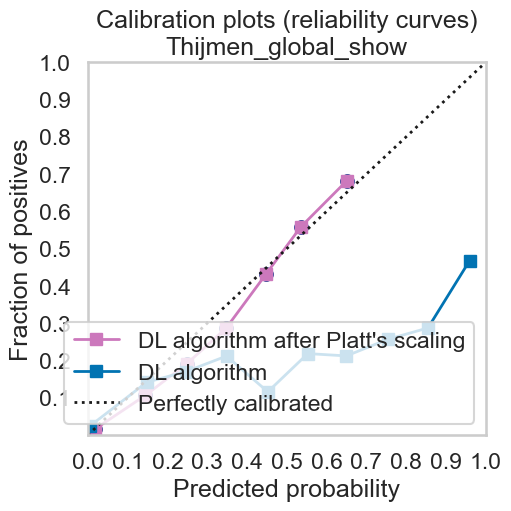

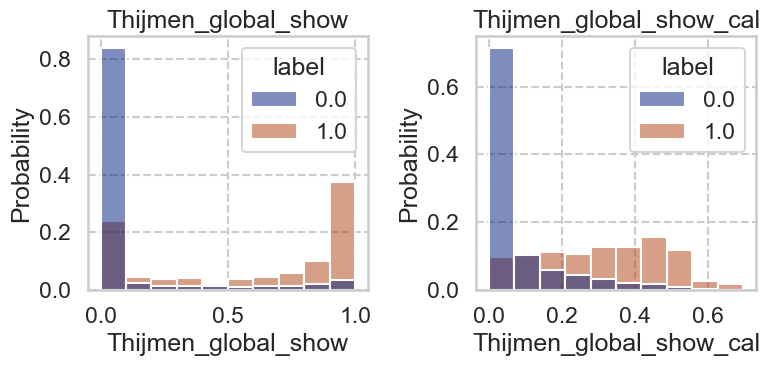

In [11]:
tijmen_dfs = {}
for model in tijmen_load_info:
    df = predictions.load_tijmen_results(
        model_name=model,
        base_path=tijmen_load_info[model]['base_path'],
        local=tijmen_load_info[model]['local'],
        valid=tijmen_load_info[model]['valid'],
    )[['AnnotationID', 'label', model]]

    df[f"{model}_cal"] = predictions.calibrate_preds(df[model], df['label'])
    predictions.make_calibration_plots(
        df['label'], df[model], df[f'{model}_cal'], 
        title=f'\n{model}')
    predictions.check_scoredists(df, [model, f'{model}_cal'])

    df.to_csv(f"{tijmen_load_info[model]['base_path']}/combined_{('valid_' if tijmen_load_info[model]['valid'] else '')}output.csv")
    tijmen_dfs[model] = df

## Merge Venk21 and De Haas Predictions

In [12]:
preds = venk21_pancan
for m in tijmen_dfs:
    preds = preds.merge(tijmen_dfs[m], how='left', on=['AnnotationID', 'label'], suffixes=(None, None))

preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter_mm                16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

## Get Series for Sybil Predictions

This includes the ones from Venk21's cross-validation set which are NOT in Sybil's training set.

In [13]:
LOAD_SYBIL_PICKLE_FILE = True

if LOAD_SYBIL_PICKLE_FILE:
    SYBIL_SERIES_JSON_PATH = f"{FILE_DIR}/sybil-nlst-pid_tp_series2split.p"
    sybil_split_dict = pickle.load(open(SYBIL_SERIES_JSON_PATH, "rb"))

    ids = list(sybil_split_dict.keys())
    splits = list(sybil_split_dict.values())
    pids = [re.split('PID-|__TimePoint-|__Series-', i)[1] for i in ids]
    timepoints = [re.split('PID-|__TimePoint-|__Series-', i)[2] for i in ids]
    siuids = [re.split('PID-|__TimePoint-|__Series-', i)[3] for i in ids]

    sybil_split_df = pd.DataFrame({'id': ids, 'split': splits, 'PatientID': pids, 'timepoint': timepoints, 'SeriesInstanceUID': siuids})

    sybil_split_df.to_csv(f"{FILE_DIR}/sybil-nlst-splitinfo.csv", index=False)

else:
    sybil_split_df = pd.read_csv(f"{FILE_DIR}/sybil-nlst-splitinfo.csv")

In [14]:
sybil_train_ids = set(sybil_split_df.query('split == "train"')['SeriesInstanceUID'])
venk21_series_ids = set(preds['SeriesInstanceUID'])
unique_series_ids = venk21_series_ids - sybil_train_ids

print("Sybil training scans:", len(sybil_train_ids))
print("Venk21 scans (cross-val.):", len(venk21_series_ids))
print("Validation set scans:", len(unique_series_ids))

Sybil training scans: 28160
Venk21 scans (cross-val.): 10183
Validation set scans: 5912


In [15]:
preds['InSybilTrain'] = preds['SeriesInstanceUID'].isin(sybil_train_ids)
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter_mm                16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

In [16]:
sybil_infer_input = preds.query("SeriesInstanceUID in @unique_series_ids")
sybil_infer_input.to_csv(f"{FILE_DIR}/sybil_val_infer_series.csv", index=False)
sybil_infer_input[['SeriesInstanceUID']].nunique()

SeriesInstanceUID    5912
dtype: int64

After this, convert MHA to DICOM and run Sybil's inference on `DIAGNijmegen/bodyct-sybil-lung-cancer-risk`.

## Merge Sybil Predictions

NOTE: I ran this in two jobs - one for the 1172 scans in the intersection with De Haas combined model's validation set, and a second for the 4739 (1 scan failed) on the rest. Ideally, you run it all at once, but I'm gonna merge them here. 

In [17]:
sybil_infer_1172 = pd.read_csv(f"{FILE_DIR}/sybil-inference-1172.csv")
sybil_infer_4739 = pd.read_csv(f"{FILE_DIR}/sybil-inference-4739.csv")
len(sybil_infer_1172), len(sybil_infer_4739)

(1172, 4739)

In [18]:
sybil_infer = pd.concat([sybil_infer_1172, sybil_infer_4739], axis=0, ignore_index=True).drop_duplicates(subset='SeriesInstanceUID')
sybil_infer = sybil_infer.rename(columns={f'year{n+1}': f'sybil_year{n+1}' for n in range(6)})
sybil_infer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SeriesInstanceUID  5911 non-null   object 
 1   sybil_year1        5911 non-null   float64
 2   sybil_year2        5911 non-null   float64
 3   sybil_year3        5911 non-null   float64
 4   sybil_year4        5911 non-null   float64
 5   sybil_year5        5911 non-null   float64
 6   sybil_year6        5911 non-null   float64
dtypes: float64(6), object(1)
memory usage: 323.4+ KB


In [19]:
allpreds = preds.merge(sybil_infer, validate='m:1',
                how="left",
                on=['SeriesInstanceUID'], suffixes=(None,None))
allpreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter_mm                16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

## Split up Nodule Type Columns

This is to make the analysis a bit easier later on.

In [20]:
allpreds['NoduleType2'] = allpreds['NoduleType']
allpreds = pd.get_dummies(allpreds, columns=['NoduleType2'], prefix='', prefix_sep='')
allpreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter_mm                16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

## Save Everything

In [21]:
allpreds.to_csv(f"{FILE_DIR}/nlst_allmodels.csv", index=False)